IMPORTS

In [36]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
from ipywidgets import interact, widgets
from IPython.display import display
import math

Wszystko oprócz R to będą slidery, albo pola tekstowe [TODO]

In [51]:
ALPHA = 0.5

NUMBER_OF_EMITERS = int(360/ALPHA)
DETECTORS = 270

L = 270

im = cv2.imread("Shepp_logan.jpg", 0)

R = min(im.shape)/2

print(R)

512.0


algorytm Bresenhama [DO OPTYMALIZACJI (TFU)]

In [52]:
def bresenhamLine(x1, y1, x2, y2):
    d,dx,dy,ai,bi,xi,yi = (0,)*7
    x,y = x1,y1
    
    coords = [(x1,y1)]
    
    if (x1 < x2):
        xi =1
        dx = x2 - x1
    else:
        xi = -1
        dx = x1 - x2
    
    if (y1 < y2):
        yi = 1
        dy = y2 - y1
    else:
        yi = -1
        dy = y1 - y2
    
    if (dx > dy):
        ai = (dy - dx) * 2
        bi = dy * 2
        d = bi - dx
        
        while (x != x2):
            if (d >= 0):
                x += xi
                y += yi
                d += ai
            else:
                d += bi
                x += xi
            coords.append((x, y))
    else:
        ai = (dx - dy) * 2
        bi = dx * 2
        d = bi - dy
        
        while (y != y2):
            if (d >=0):
                x += xi
                y += yi
                d += ai
            else:
                d += bi
                y += yi
            coords.append((x, y))
    coords.append((x2,y2))
    return coords

Te dwie komórki niżej są wprost ze wzoru http://www.cs.put.poznan.pl/swilk/pmwiki/uploads/Dydaktyka/tomograf-wzory.pdf

\+ jest wyśrodkowane czyli +R na x i y, bo OpenCV tak bierze coordy:

0,0 - - - ->X<br>
|<br>
|<br>
|<br>
v<br>
Y<br>

In [53]:
def getEmiterPosition(r, alpha):
    x = r * np.cos( np.radians(alpha)) + R
    y = r * np.sin( np.radians(alpha)) + R
    return (int(x),int(y))

In [54]:
def getSensorPosition(r, alpha, fi, i, numberOfSensors):
    x = r * np.cos (np.radians(alpha) + np.pi - np.radians(fi)/2 + (i * ( np.radians(fi) / (numberOfSensors-1) )) ) + R
    y = r * np.sin (np.radians(alpha) + np.pi - np.radians(fi)/2 + (i * ( np.radians(fi) / (numberOfSensors-1) )) ) + R
    return (int(x),int(y))

def getAllSensors(r, alpha, fi, numberOfSensors):
    sensors = []
    for i in range(numberOfSensors):
        sensors.append(getSensorPosition(r, alpha, fi, i, numberOfSensors))
    return sensors

In [61]:
"""
Sinogram X -> sensor
         Y -> emiter
         
         To jest zrobione addytywnie, ale nie wiem czy to dobrze działa, trzeba sprawdzić
"""

def sinogram(r, fi, image, ifFiltr, filtr):
    
    sinogram = np.zeros([NUMBER_OF_EMITERS,DETECTORS])
    
    
    for i in range(NUMBER_OF_EMITERS):
        emiter = getEmiterPosition(r, ALPHA * i)
        sensors = getAllSensors(r, ALPHA * i, L, DETECTORS)
        for j,sensor in enumerate(sensors):
            misc = 0
            coords = bresenhamLine(emiter[0],emiter[1],sensor[0],sensor[1])
            for coord in  coords:
                misc += image[coord[0]-1][coord[1]-1]
            #misc = misc/len(coords)
            sinogram[i][j] += misc
    if(ifFiltr):
        for k in range(sinogram.shape[0]):
            sinogram[k]=np.convolve(sinogram[k],filtr, mode='same')

    
    sinogram = (sinogram - np.amin(sinogram)) / (np.amax(sinogram) - np.amin(sinogram))
    plt.imshow(sinogram, cmap='gray')
    return sinogram
    

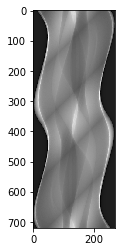

In [62]:
filtr = [1]

for i in range(1,21):
    if (i)%2:
        filtr.append(0)
    else:
        x=(-4/(math.pi)**2)/((i)**2)
        filtr.append(x)

filtr =  filtr[:0:-1]+filtr

Sin = sinogram(R, L, im, True, filtr)

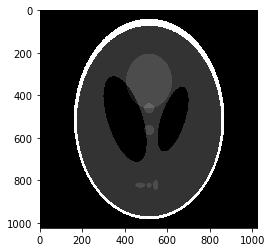

In [63]:
plt.imshow(im, cmap='gray')

In [64]:
def masked_normal(x):
    z = x * 1
    minval = np.amin(x[np.nonzero(x)])
    maxval = np.amax(x[np.nonzero(x)])
    print(minval, maxval)

    for i, k in enumerate(x):
        for j, l in enumerate(k):
            if l != 0:
                z[i][j] = (l-minval)/(maxval-minval)
            else:
                z[i][j] = 0
    return z


In [65]:
def reverseSinogram(r, fi, sinogram):
    gif = []
    revSin = np.zeros([im.shape[0], im.shape[1]])
    counter = np.zeros([im.shape[0], im.shape[1]])
    for i in range(NUMBER_OF_EMITERS):
        emiter = getEmiterPosition(r, ALPHA * i)
        sensors = getAllSensors(r, ALPHA * i, L, DETECTORS)
        for j,sensor in enumerate(sensors):
            coords = bresenhamLine(sensor[0],sensor[1],emiter[0],emiter[1])
            for coord in  coords:
                revSin[coord[0]-1][coord[1]-1] += sinogram[i][j]
                counter[coord[0]-1][coord[1]-1]  += 1
        gif.append(revSin)
        if(i%90==0):
            cv2.imwrite("gif"+str(i)+".png",revSin)
    #revSin = (revSin - np.amin(revSin)) / (np.amax(revSin) - np.amin(revSin))*255
    #revSin = masked_normal(revSin) * 255
    for x in range(revSin.shape[0]):
        for y in range(revSin.shape[1]):
            if counter[x][y]!=0:
                revSin[x][y] = revSin[x][y]/counter[x][y]
    cv2.imwrite("gif"+str(NUMBER_OF_EMITERS)+".png",revSin*255)
    plt.imshow(revSin, cmap='gray')
    return gif 

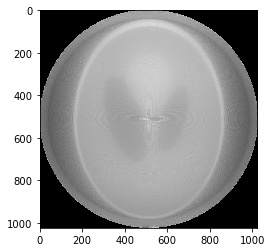

In [66]:
gif = reverseSinogram(R, L, Sin)

In [ ]:
"""

if filter:
        sinogram = result.copy()
        f = fftfreq(sinogram.shape[0]).reshape(-1, 1)  # digital frequency
        fourier_filter = 2 * np.abs(f)  # ramp filter

        projection = fft(sinogram, axis=0) * fourier_filter
        sinogram = np.real(ifft(projection, axis=0))
        return sinogram/sinogram.max()

Notatki z iwm

convolve same !!!!

maska 41 elementów

"""